In [1]:
from collections import defaultdict
from functools import partial
from itertools import chain
from pathlib import Path
import shutil
import re

from cytoolz import groupby
from cytoolz.curried import get
from gPhoton.coadd import coadd_image_slices
from gPhoton.pretty import print_stats
from killscreen.monitors import Netstat, Stopwatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv
from pyarrow import parquet

from s3_fuse.mount_s3 import mount_bucket
from s3_fuse.ps1_utils import prune_ps1_catalog, get_ps1_cutouts
from s3_fuse.galex_utils import get_galex_cutouts
from s3_fuse.utilz import make_loaders, sample_table, parse_topline

%matplotlib notebook

In [2]:
# 'configuration'

BUCKET = 'nishapur'
S3_ROOT = '/mnt/s3'

mount_bucket(
    backend="goofys", remount=False, mount_path=S3_ROOT, bucket=BUCKET
)

# desired cutout side length in degrees
CUTOUT_SIDE_LENGTH = 60 / 3600

# which PS1 bands are we looking at? (currently only g and z are staged.)
PS1_BANDS = ("g", "z")
# shall we do GALEX stuff?
DO_GALEX_STUFF = False

# select loaders -- options are "astropy", "fitsio", "greedy_astropy", "greedy_fitsio"
# NOTE: because all the files this particular notebook is looking
# at are RICE-compressed, there is unlikely to be much difference
# between astropy and greedy_astropy -- astropy does not support
# loading individual tiles from a a tile-compressed FITS file.
LOADERS = make_loaders("fitsio",)

In [3]:
# catalog of PS1 extragalactic extended objects, including explicit 
# assignments to PS1 stack image projection / sky cells and GALEX 
# eclipse numbers
catalog_fn = "ps1_extragalactic_skycells_eclipses.parquet"
if not Path(catalog_fn).exists():
    shutil.copy(
        Path(S3_ROOT, "ps1/metadata", catalog_fn),
        Path(catalog_fn)
    )
catalog = parquet.read_table(catalog_fn)

# for this demo, we only staged a subset of those PS1 stack images 
# (all of them at all 5 bands would be > 80 TB). this is a list of 
# the (randomly selected) projection and sky cells we staged.
test_cell_fn = "ps1_extragalactic_skycells_eclipses_1k_cell_subset.csv"
arbitrary_test_cells = (
    pa.csv
    .read_csv(Path(S3_ROOT, "ps1/metadata", test_cell_fn))
    .cast(pa.schema([("proj_cell", pa.uint16()), ("sky_cell", pa.uint8())]))
)
small_catalog = prune_ps1_catalog(catalog, arbitrary_test_cells)

# and a little pruning on GALEX: this is a table of actually-existing MIS-like 
# images by eclipse number, excluding eclipses with data currently flagged as bad
extant_mislike = pd.read_csv(Path(S3_ROOT, "extant_mislike_eclipses.csv"))['0']

In [22]:
# how many objects shall we collect slices for? (785510 are available in this test set)
TARGET_COUNT = 16
# optional parameter -- restrict the total number of PS1 source cells to test the 
# performance effects of denser sampling (1000 total PS1 cells are available in this test set).
# note that the number of actual images accessed is a factor of both the number of cells
# and the number of bands under consideration.
# if GALEX fusion is taking place, this will also indirectly
# restrict the number of GALEX images.
MAX_CELL_COUNT = 3
if MAX_CELL_COUNT is not None:
    test_catalog = prune_ps1_catalog(
        small_catalog, sample_table(arbitrary_test_cells, k=MAX_CELL_COUNT)
    )
else:
    test_catalog = small_catalog
targets = sample_table(test_catalog, k=TARGET_COUNT).to_pylist()
ps1_stacks = set(map(get(['proj_cell', 'sky_cell']), targets))
galex_eclipses = {
    e for e in tuple(chain.from_iterable(map(get('galex'), targets)))
    if e in extant_mislike.values
}

In [23]:
# per-loader performance-tuning parameters
# image_chunksize: how many images shall we initialize at once?
# image_threads: how many threads shall we init with in parallel? (None to disable.)
# cut_threads: how many threads shall we cut with in parallel? (None to disable.)
TUNING = {
    "fitsio": {"image_chunksize": 40, "image_threads": 7, "cut_threads": 7},
    "greedy_fitsio": {"image_chunksize": 40, "image_threads": 4, "cut_threads": None},
    "default": {"image_chunksize": 40, "image_threads": 4, "cut_threads": 4},
}

In [24]:
ps1_groups = groupby(get(['proj_cell', 'sky_cell']), targets)
ps1_cutouts = {}
logs = {}
DO_GALEX_STUFF = True
for loader_name, loader in LOADERS.items():
    # remount bucket to avoid "cheating" -- note that this is still a little cheaty
    # because of unreliable, unmodifiable, and entirely black-box caching on S3 side, and loaders
    # later in the list will tend to do better. for a 'fairer' comparison, reroll
    # between each loader.
    print(f"----testing {loader_name}----")
    mount_bucket(
        backend="goofys", remount=True, mount_path=S3_ROOT, bucket=BUCKET
    )
    tuning_params = TUNING[loader_name] if loader_name in TUNING.keys() else TUNING["default"]
    ps1_cuts, logs[loader_name] = get_ps1_cutouts(
        ps1_stacks, 
        loader, 
        targets, 
        CUTOUT_SIDE_LENGTH, 
        f"{S3_ROOT}/ps1", 
        PS1_BANDS,
        verbose=2,
        **tuning_params
    )
    rate, weight = parse_topline(logs[loader_name])
    print(f"{rate} cutouts/s, {weight} MB / cutout")
    if DO_GALEX_STUFF is True:
        galex_slices, logs[f"{loader_name}_galex"] = get_galex_cutouts(
            galex_eclipses,
            loader,
            targets,
            CUTOUT_SIDE_LENGTH,
            f"{S3_ROOT}",
            ["NUV"],
            **tuning_params
        )
        rate, weight = parse_topline(logs[f"{loader_name}_galex"])
        print(f"{rate} cutouts/s, {weight} MB / cutout")
        watch = Stopwatch(silent=True)
        watch.start()
        galex_coadds, coadd_wcs = {}, {}
        print(
            f"...coadding {len(galex_slices)} image slices...", 
            end=""
        )
        # cutouts chunked by obj_id -- each item in obj_slices
        # is a list of cuts around a single sky position
        # taken from all eclipses which we found that sky position
        obj_slices = groupby('obj_id', galex_slices)
        for obj_id, images in obj_slices.items():
            if len(images) == 0:
                print("all GALEX images for {obj_id} are bad, skipping")
            galex_coadds[obj_id], coadd_wcs[obj_id] = coadd_image_slices(images)
        print(f"coadded GALEX cutouts,{watch.peek()}s")


----testing fitsio----
initialized 6 images,0.71 s,2.1 MB
made 32 cutouts,1.57 s,87.24 MB
made 32 cuts from 6 images,2.29 total s,89.34 total MB
13.97 cutouts/s, 2.79 MB / cutout
made 49 cuts from 9 images,2.58 total s,22.36 total MB
18.99 cutouts/s, 0.46 MB / cutout
...coadding 49 image slices...coadded GALEX cutouts,0.03s


<IPython.core.display.Javascript object>


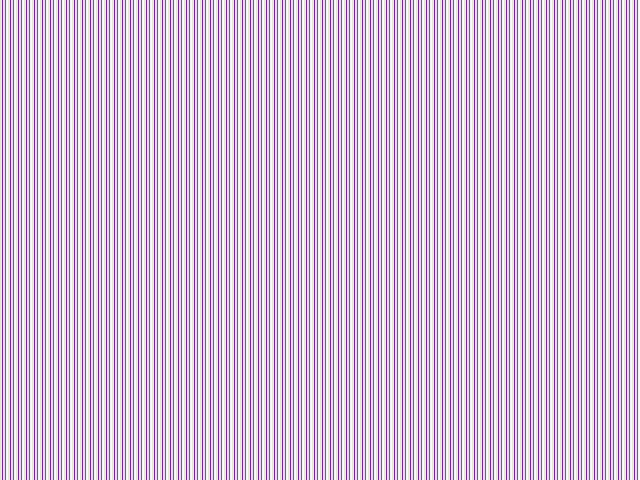

In [25]:
def centile_clip(array, percentiles):
    low, high = np.percentile(array, percentiles)
    return np.clip(array, low, high)

galex_coadds = {k: galex_coadds[k] for k in sorted(galex_coadds.keys())}
clipper = partial(centile_clip, percentiles = (5, 99))
galex_frames = tuple(map(clipper, galex_coadds.values()))
square = int(len(galex_frames)**(0.5))

fig, grid = plt.subplot_mosaic(np.arange(square**2).reshape((square,square)))
for ix, cell in grid.items():
    cell.set_axis_off()
    cell.imshow(galex_frames[ix], cmap='cividis')

<IPython.core.display.Javascript object>


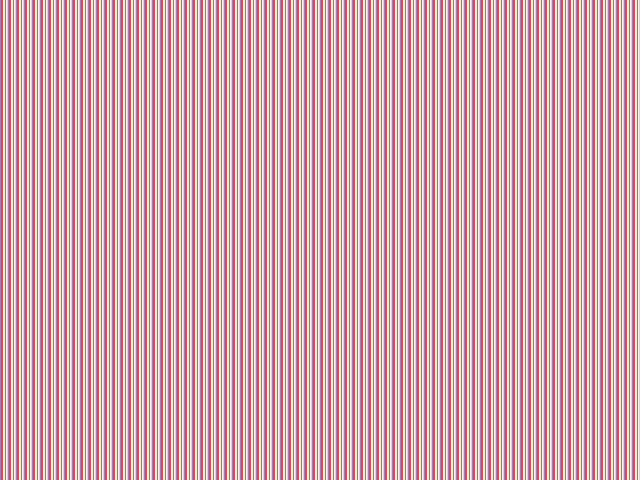

In [26]:
ps1_cuts = sorted(ps1_cuts, key=lambda cut: cut['obj_id'])
ps1_frames = tuple(map(clipper, [cut['arrays'][0] for cut in ps1_cuts if '.g.' in cut['path']]))
square = int(len(ps1_frames)**(0.5))

fig, grid = plt.subplot_mosaic(np.arange(square**2).reshape((square,square)))
for ix, cell in grid.items():
    cell.set_axis_off()
    cell.imshow(ps1_frames[ix], cmap='hot')